In [ ]:
# CNN


In [26]:
# IMPORTS
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers, models
from keras import backend as K
from keras import regularizers
from collections import namedtuple
import math
import matplotlib.pyplot as plt
import pickle
import datetime
import os
Point = namedtuple('Point', ('x', 'y'))
Circle = namedtuple('Circle', ('r'))
Square = namedtuple('Square', ('side'))
Rectangle = namedtuple('Rectangle', ('length', 'width'))
PointWithDistance = namedtuple('PointWithDistance', ('p', 'dist'))
float_memory_used = 'float32'

In [2]:
# LOAD DATA
dataframe = pd.read_csv('ML/data/dynamic_pus_using_pus50000_15PUs_201912_0623_57.txt', delimiter=',', header=None)
dataframe_max = pd.read_csv('ML/data/dynamic_pus_max_power50000_15PUs_201912_0623_57.txt', delimiter=',', header=None)

dataframe.reset_index(drop=True, inplace=True)
dataframe_max.reset_index(drop=True, inplace=True)

dataframe_tot = pd.concat([dataframe, dataframe_max.iloc[:, dataframe_max.columns.values[-1]]], axis=1,
                        ignore_index=True)
idx = dataframe_tot[dataframe_tot[dataframe_tot.columns[-1]] == -float('inf')].index
dataframe_tot.drop(idx, inplace=True)

data_reg = np.concatenate((dataframe_tot.values[:, 0:dataframe_tot.shape[1]-3], 
                           dataframe_tot.values[:, dataframe_tot.shape[1]-1:dataframe_tot.shape[1]]), axis=1)
data_class = dataframe_tot.values[:, 0:dataframe_tot.shape[1]-1]
y_class_power = dataframe_tot.values[:, -1]
del dataframe, dataframe_max

In [15]:
# INIT
number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 1001, 1000))
number_samples = [150]

validation_size, noise_floor = 0.33, -90.0
su_power = 0 # this is not actually su power just a number to show there is an SU in its image
max_x, max_y, number_image_channels, su_szie = 1000, 1000, 1, 10
pu_shape, su_shape = 'circle', 'square'
pus_num, intensity_degradation, slope = 15, 'log', 4
if su_shape == 'circle':
    su_param = Circle(su_szie)
elif su_shape == 'square':
    su_param = Square(su_szie)
num_pus = (data_reg.shape[1] - 3)//3
dtime = datetime.datetime.now().strftime('_%Y%m_%d%H_%M')
color = "color" if number_image_channels > 1 else "grey"
image_dir = 'ML/data/pictures_' + str(max_x) + '_' + str(max_y) + '/pu_' + pu_shape + '_su_' + su_shape + '_' + str(
    su_szie) + "/" + color +'/' + intensity_degradation + '_' + str(slope)

In [9]:
def euclidian_distance(p1: Point, p2: Point):
    return ((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) ** 0.5

def calculate_mu_sigma(data, num_pus):
    sum_non_noise = 0
    for pu_n in range(num_pus): # calculate mu
        sum_non_noise += data[pu_n*3+2]
    mu = ((max_x * max_y - num_pus) * noise_floor + sum_non_noise)/(max_x * max_y)
    sum_square = 0
    for pu_n in range(num_pus): # calculate sigma
        sum_square += (data[pu_n*3+2]-mu)**2
    sum_square += (max_x * max_y - num_pus) * (noise_floor - mu)**2
    sigma = math.sqrt(sum_square/(max_x * max_y))
    return mu, sigma

def create_image(data, pus_num, slope, style="raw_power_z_score", noise_floor=-90, pu_shape= 'circle', pu_param=None, 
                 su_shape='circle', su_param=None, intensity_degradation="log"):  
    # style = {"raw_power_z_score", "image_intensity"}
    # intensity_degradation= {"log", "linear"}
    # if param is None, it's automatically calculated. Highest brightness(or power value) (255 or 1.) would
    # assigned to the center(PU location) and radius(side) would be calculated based on its power, slope, and noise floor.
    # If it is given, intensity(power) of pixel beside center would be calculated in the same fashin with an exception that 
    # intensity below zero(noise_floor) would be replaced by zero(noise_floor)
    if style == "raw_power_z_score":
        pass
        # In this way, PUs' location are replaced with their power(dBm) and the power would fade with 
        # slope till gets noise_floor(in circle shape)
#         pu_image = [[(noise_floor - mu)/sigma] * max_y for _ in range(max_x)]
    elif style == "image_intensity":
        # creating PU image
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        for pu_i in range(pus_num):
            pu_x, pu_y, pu_p = max(0, min(max_x-1, int(data[pu_i*3]))), max(0, min(max_x-1, int(data[pu_i*3+1]))), data[pu_i*3+2]
            if pu_param is None:
                if pu_shape == 'circle':
                    if intensity_degradation == "linear":
                        pu_param = Circle(math.ceil((pu_p - noise_floor) / slope)) # linear
                    elif intensity_degradation == "log":
                        pu_param = Circle(math.ceil(10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
                elif pu_shape == 'square':
                    if intensity_degradation == "linear":
                        pu_param = Square(math.ceil(2 ** 0.5 * (pu_p - noise_floor) / slope)) # linear
                    elif intensity_degradation == "log":
                        pu_param = Square(math.ceil(2 ** 0.5 * 10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
                else:
                    raise ValueError("Unsupported PU shape(create_image)! ", pu_shape)
            points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                        image[0][0][point.p.x][point.p.y] += max((pu_p - slope * point.dist + abs(noise_floor))
                                                              /(pu_p + abs(noise_floor)), 0)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            image[0][0][point.p.x][point.p.y] = 1
                        else:
                            image[0][0][point.p.x][point.p.y] += max((pu_p - slope * 10*math.log10(point.dist) + abs(noise_floor))
                                                                 /(pu_p + abs(noise_floor)), 0)
                    image[0][0][point.p.x][point.p.y] = min(image[0][0][point.p.x][point.p.y], 1.0)
                        
        # creating SU image
        su_num = (len(data) - pus_num * 3) // 2
        if not (len(data) - pus_num * 3) % 2:
            raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
#         su_image = np.zeros((max_x, max_y), dtype=float_memory_used)
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        su_intensity = 1.
        for su_i in range(su_num):
            su_x, su_y, su_p = max(0, min(max_x-1, int(data[pus_num*3+su_i*2]))
                                  ), max(0, min(max_x-1, int(data[pus_num*3+su_i*2+1]))), su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if number_image_channels > 1:
                        image[0][1][point.p.x][point.p.y] = su_intensity
                    elif number_image_channels == 1:
                        image[0][0][point.p.x][point.p.y] = su_intensity
#         return np.array([pu_image, su_image, [[0.] * max_y for _ in range(max_x)]], dtype='float32') # return like this to be able to display as an RGB image with pyplot.imshow(imsave)
#         return np.append(pu_image, su_image, axis=0)
        return image
        
            
    else:
        raise ValueError("Unsupported style(create_image)! ", style)
        
def points_inside_shape(center: Point, shape: str, param)-> list:
    # This function returns points+distance around center with defined shape
    if shape == 'circle':
        # First creates points inside a square(around orgigin) with 2*r side and then remove those with distance > r.
        # Shift all remaining around center. O(4r^2)
        r, origin = param.r, Point(0, 0)
        square_points = set([Point(x, y) for x in range(-r, r+1) for y in range(-r, r+1)])
        points = []
        while square_points:
            p = square_points.pop()
            dist = euclidian_distance(p, origin)
            if dist <= r:
                points.append(PointWithDistance(Point(p.x + center.x, p.y + center.y), dist))
                if p.x != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, p.y + center.y), dist))
                    square_points.remove(Point(-p.x, p.y))
                if p.y != 0:
                    points.append(PointWithDistance(Point(p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(p.x, -p.y))
                if p.x != 0 and p.y != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(-p.x, -p.y))
        return points
    elif shape == 'square':
        half_side = param.side // 2
        return [PointWithDistance(Point(x, y), euclidian_distance(Point(x, y), center)) for x in range(-half_side + center.x,
                                                                                               half_side + center.x+1) 
                         for y in range(-half_side + center.y, half_side + center.y + 1)]
    else:
        raise ValueError("Unsupported shape(points_inside_shape)! ", shape)
    
# TODO: Consider using min_max normalization becasue difference between values using
# z-score is huge since most of the pixels have the same value, noise floor

In [10]:
# Saving images once to save time
# run this cell just for creating images
if not os.path.exists(image_dir):
    os.makedirs(image_dir)
# for image_num in range(115, data_reg.shape[0]):
for image_num in range(0, 500):
    image = create_image(data=data_reg[image_num], slope=slope, style="image_intensity", noise_floor=noise_floor,
                         pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, pus_num=pus_num, 
                         intensity_degradation=intensity_degradation)
    if number_image_channels != 3:
        image = np.append(np.array(image[0]), np.zeros((3-number_image_channels,max_x, max_y), 
                                                       dtype=float_memory_used), axis=0)
    image_save = np.swapaxes(image, 0, 2)
    plt.imsave(image_dir + '/image' + str(image_num)+'.png', image_save)
    if image_num + 1 % 100 == 0:
        print(image_num)

In [68]:
# TODO, CNN Model here
def cnn_model(num_filters, lam):
#     num_filters, lam = 5, 5
    data_format = 'channels_first'
    convolution_filter, dense_filter = 'relu', 'linear' #softsign, sigmoid; relu, linear
    filter_shape, pool_size = (10, 10), (3,3)
    cnn = models.Sequential()
    cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, 
                          input_shape=(number_image_channels, max_x, max_y), data_format=data_format, 
                          kernel_regularizer=regularizers.l2(lam), bias_regularizer=regularizers.l2(lam)))
    cnn.add(layers.MaxPooling2D(pool_size=pool_size, data_format=data_format))
    cnn.add(layers.Conv2D(num_filters, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(lam), bias_regularizer=regularizers.l2(lam)))
    cnn.add(layers.MaxPool2D(pool_size=pool_size, data_format=data_format))
#     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                          kernel_regularizer=regularizers.l2(lam), bias_regularizer=regularizers.l2(lam)))
#     cnn.add(layers.MaxPool2D(pool_size, data_format=data_format))
#     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format, 
#                          kernel_regularizer=regularizers.l2(lam), bias_regularizer=regularizers.l2(lam)))
#     cnn.add(layers.MaxPool2D(pool_size, data_format=data_format))
#     cnn.add(layers.Conv2D(num_filters, filter_shape, padding='same', activation=convolution_filter, data_format=data_format))
#     cnn.add(layers.MaxPool2D(pool_size, data_format=data_format))
    cnn.add(layers.Flatten())
    # cnn.add(layers.Dense(5, activation=dense_filter))
    cnn.add(layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(lam),
                         bias_regularizer=regularizers.l2(lam)))
    return cnn

In [69]:
cnn = cnn_model(5, 1)

In [70]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 5, 1000, 1000)     505       
_________________________________________________________________
max_pooling2d_111 (MaxPoolin (None, 5, 333, 333)       0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 5, 333, 333)       2505      
_________________________________________________________________
max_pooling2d_112 (MaxPoolin (None, 5, 111, 111)       0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 61605)             0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 61606     
Total params: 64,616
Trainable params: 64,616
Non-trainable params: 0
_________________________________________________________________


In [71]:
# CNN
# prev_sample = 0
# max_train_samples = math.ceil(number_samples[-1] * (1 + validation_size))
# x_train = np.empty((max_train_samples, number_image_channels, max_x, max_y), dtype=float_memory_used)
# y_train = np.empty((max_train_samples), dtype=float_memory_used)
# average_diff_power, fp_mean_power = [], []
for number_sample in number_samples:
    sample = math.ceil(number_sample * (1 + validation_size))
    for image_num in range(prev_sample, sample):
        prev_sample = sample
        image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
        image = np.swapaxes(image, 0, 2)
        x_train[image_num] = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
        y_train[image_num] = np.asarray(data_reg[image_num][-1], dtype=float_memory_used)
        del image
        if image_num + 1 % 100 == 0:
            print(image_num)
    cnn = cnn_model(5, 1)
    cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae'])
    cnn.fit(x_train[:sample], y_train[:sample], epochs=5, verbose=1, batch_size=1, validation_split=validation_size)
    
    # evaluating test images
    sum_mae, sum_fp_mae = 0, 0
    test_size = 0
#     for test_num in range(max_train_samples, data_reg.shape[0]):
    for test_num in range(sample, 500):
        test_size += 1
        test_image = plt.imread(image_dir + '/image' + str(test_num) + '.png')
        test_image = np.swapaxes(test_image, 0, 2)
        test_image = np.array(test_image[:number_image_channels]).reshape(1, number_image_channels, max_x, max_y)
        test_y = data_reg[test_num][-1]
        test_yp = cnn.predict(test_image)[0][0]
        sum_mae += abs(test_yp - test_y)
        if test_yp > test_y:
            sum_fp_mae += abs(test_yp - test_y)
        if test_num % 500 == 0:
            print('test: ', test_num)
    fp_mean_power.append(round(sum_fp_mae/ test_size, 3))
    average_diff_power.append(round(sum_mae / test_size, 3))
    print('number_samples: ', number_sample, ', average_error: ', average_diff_power[-1], ' fp_average_error: ', fp_mean_power[-1])
    
#     var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + dtime + ".dat", "wb") # file for saving results
#     pickle.dump([average_diff_power, fp_mean_power, number_samples], file=var_f)
#     var_f.close()       

Train on 134 samples, validate on 66 samples
Epoch 1/5
134/134 [==============================] - 74s 554ms/step - loss: 266.4205 - mean_squared_error: 256.5165 - mean_absolute_error: 12.9741 - val_loss: 96.6204 - val_mean_squared_error: 85.7242 - val_mean_absolute_error: 7.4998
Epoch 2/5
134/134 [==============================] - 72s 540ms/step - loss: 117.6809 - mean_squared_error: 106.7643 - mean_absolute_error: 7.8762 - val_loss: 92.1600 - val_mean_squared_error: 81.6229 - val_mean_absolute_error: 7.0769
Epoch 3/5
134/134 [==============================] - 71s 527ms/step - loss: 93.0819 - mean_squared_error: 82.5056 - mean_absolute_error: 7.0081 - val_loss: 127.2116 - val_mean_squared_error: 116.3379 - val_mean_absolute_error: 8.6044
Epoch 4/5
134/134 [==============================] - 71s 527ms/step - loss: 73.5808 - mean_squared_error: 61.8423 - mean_absolute_error: 6.1326 - val_loss: 141.0335 - val_mean_squared_error: 129.0991 - val_mean_absolute_error: 8.9377
Epoch 5/5
 16/134 

KeyboardInterrupt: 

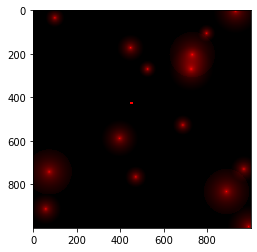

In [56]:
# just run to dispaly the image. First change return line from create_image
aa = np.swapaxes(np.append(np.array(x_train[50]), np.zeros((2,max_x, max_y), dtype=float_memory_used), axis=0), 0, 2)
plt.imshow(aa)
# plt.imsave('image.png', aa)

In [ ]:
data_reg.shape

In [ ]:
cnn.summary()

In [ ]:
# use this cell to read saved variables
var_ff = open('ML/data/pictures_1000_1000/log_201912_0705_37.txt', 'rb')
[average_diff_power_1, fp_mean_power_1, number_samples_1] = pickle.load(var_ff)

In [ ]:
fp_mean_power

In [ ]:
average_diff_power[-1]*(data_reg.shape[0] - max_train_samples)/(300-sample)

In [ ]:
sum_fp_mae/200

In [ ]:
fp_mean_power

In [ ]:
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 1001, 1000))

# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 1000, 1000, 2, 10
# pu_shape, su_shape = 'circle', 'square'
# pus_num, intensity_degradation, slope = 15, 'log', 4
# average_diff_power = [9.110476626067186, 21.070721128267266, 9.389938883165568, 10.886098907990405,
#                                        7.697396928362106, 7.522477509027216, 9.493729427772132, 8.198866980620753,
#                                        7.781910785203122, 9.41743984825801, 8.499455442627129, 9.86776958065812,
#                                        9.033719411254367, 8.150143941293027, 8.963829050517273, 8.708150642874065,
#                                        7.468060397898071, 8.233182799553932,8.206, 7.768]
# fp_mean_power =  [8.174990557021465, 0.18043087058937837, 1.5141939559853392, 10.273307557711494,
#                                    3.2306742061521443, 4.423113329284006, 8.674172526579392, 2.38235061342411,
#                                    5.014172646429496, 6.884079514994618, 3.4544130456368367, 7.81721202679044,
#                                    6.438635364829745, 4.069245107144559, 5.202978504937615, 3.405858414831347,
#                                    4.117573271657338, 2.8100743146184377, 3.951, 3.502]

In [ ]:
### MAX_POWER ANAlysis
# number_samples = [5] + list(range(10, 101, 10)) + [120, 150, 200, 250, 300, 400, 500, 700] + list(range(1000, 1001, 1000))

# validation_size, noise_floor = 0.33, -90.0
# su_power = 0 # this is not actually su power just a number to show there is an SU in its image
# max_x, max_y, number_image_channels, su_szie = 1000, 1000, 2, 10
# pus_num, intensity_degradation, slope = 15, 'log', 4
# pu_shape, su_shape = 'circle', 'circle'
# test_size = 3670
# average_diff_power = [7.811849328268183, 9.178415418536536, 8.11891504382307, 7.881934146750136, 7.918868224324312,
#                       7.709452054502398, 7.471729821563216, 8.63783455122861, 7.7635068514166345, 8.557134470036884,
#                       8.103793715416188, 9.189284948409279, 11.977416480154307, 8.291134394492891, 8.960065032512803,
#                       9.992745143323642, 8.475335283779392, 8.051642160173987, 7.322538645284376, 7.768582958795206]
# fp_mean_power = [6.1844398077234635, 1.6157812496465958, 6.5620574110067595, 2.898169187355567, 6.262096880097353,
#                  2.5478307871639267, 3.5784209073932067, 7.416731632966506, 5.5822838290638135, 5.800529848947965,
#                  4.6984887763519785, 2.337296353076653, 9.85739104089764, 3.710259461284922, 5.323224159423669, 
#                  6.198328912769283, 2.302462751745074, 4.023802978234984, 3.781413967880959, 3.2793608103510508]



In [ ]:
line_width = 5
marker_size = 12
reg_style = 'solid'
class_reg = 'dashed'
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(1,1,1)
plt.plot(number_samples, average_diff_power, color='r', linewidth=line_width, markersize=marker_size, linestyle=class_reg)
plt.plot(number_samples, fp_mean_power, color='midnightblue', linewidth=line_width, markersize=marker_size, linestyle=class_reg)
plt.xlabel('# of Training Samples', fontsize=47)
plt.ylabel('Avg. Diff. wrt Opt. (dB)', fontsize=45)
# plt.title('Mean Power Error(Static PUs)')
plt.grid(True)

ax.set_yticks(np.arange(0,20, 2))
plt.rcParams.update({'font.size': 42})
ax.tick_params(axis='x', labelsize=46)
ax.tick_params(axis='y', labelsize=45)

# matplotlib.rcParams.update({'font.size': 22})

ax.set_ylim([1, 20])
ax.set_xlim([0, 1000])
plt.legend(['Total', 'False-Positive'], ncol=2, loc='best', handletextpad=0.1,borderpad=0, columnspacing=0.2, borderaxespad=0.2)
# plt.legend(handletextpad=0.1)
plt.savefig('/'.join(image_dir.split('/')[:-1]) +  '/' + intensity_degradation + '_' + str(slope) + '_' + dtime + ".png", 
            bbox_inches = 'tight', pad_inches = 0)